In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import joblib

In [9]:

# Step 2: Load Dataset
from google.colab import drive
drive.mount('/content/drive')

# 📅 Load the Training Dataset
df = pd.read_csv('/content/drive/MyDrive/LDP/application_train.csv')

# Show basic info
df.info()
df.head()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93100 entries, 0 to 93099
Columns: 122 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(104), int64(2), object(16)
memory usage: 86.7+ MB


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0.0,202500.0,406597.5,24700.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,100003,0,Cash loans,F,N,N,0.0,270000.0,1293502.5,35698.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,100004,0,Revolving loans,M,Y,Y,0.0,67500.0,135000.0,6750.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,100006,0,Cash loans,F,N,Y,0.0,135000.0,312682.5,29686.5,...,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
4,100007,0,Cash loans,M,N,Y,0.0,121500.0,513000.0,21865.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Initial Exploration**

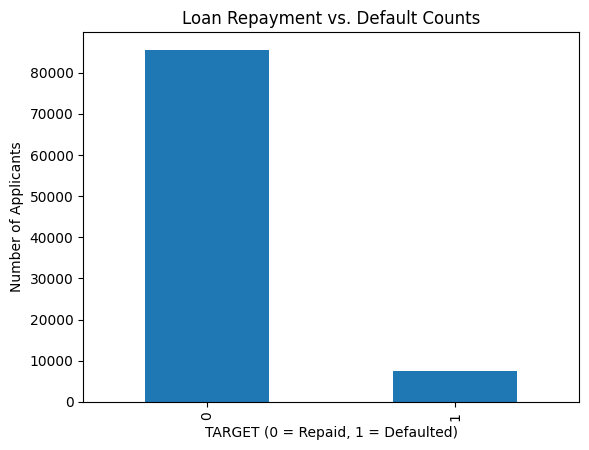

In [10]:
target_counts = df['TARGET'].value_counts()
target_counts.plot(kind='bar')
plt.title('Loan Repayment vs. Default Counts')
plt.xlabel('TARGET (0 = Repaid, 1 = Defaulted)')
plt.ylabel('Number of Applicants')
plt.show()

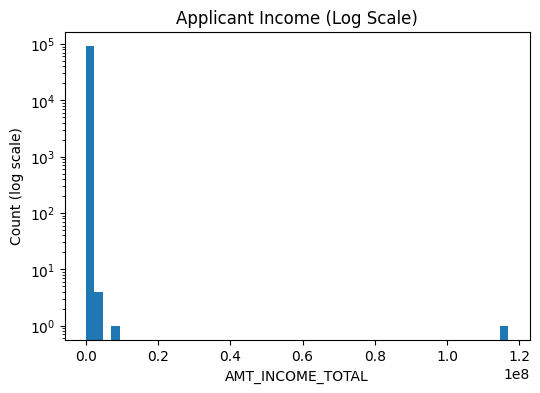

<ipython-input-11-598711889>:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(


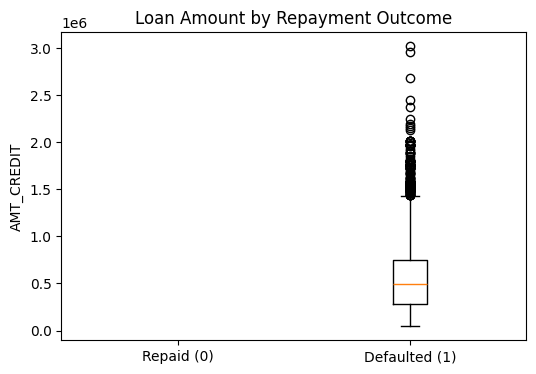

In [11]:
import matplotlib.pyplot as plt

# 1) Income distribution (log scale)
plt.figure(figsize=(6,4))
plt.hist(df['AMT_INCOME_TOTAL'], bins=50, log=True)
plt.title('Applicant Income (Log Scale)')
plt.xlabel('AMT_INCOME_TOTAL')
plt.ylabel('Count (log scale)')
plt.show()

# 2) Loan amount vs. default
plt.figure(figsize=(6,4))
plt.boxplot(
    [df.loc[df.TARGET==0, 'AMT_CREDIT'],
     df.loc[df.TARGET==1, 'AMT_CREDIT']],
    labels=['Repaid (0)','Defaulted (1)']
)
plt.title('Loan Amount by Repayment Outcome')
plt.ylabel('AMT_CREDIT')
plt.show()

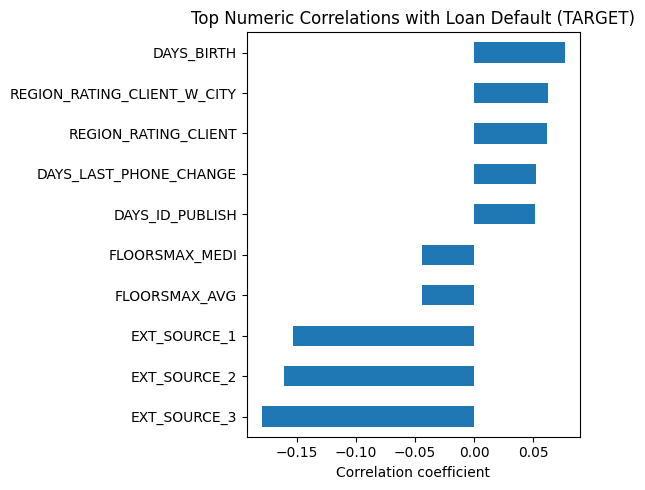

In [12]:
# 📌 Correlation with Target
import pandas as pd
import matplotlib.pyplot as plt

# Compute correlation of each numeric column with TARGET
num_corr = df.select_dtypes('number').corr()['TARGET'].drop('TARGET').sort_values()

# Take the 5 strongest negative and 5 strongest positive correlations
top_corr = pd.concat([num_corr.head(5), num_corr.tail(5)])

# Plot the results
plt.figure(figsize=(6,5))
top_corr.plot(kind='barh')
plt.title('Top Numeric Correlations with Loan Default (TARGET)')
plt.xlabel('Correlation coefficient')
plt.tight_layout()
plt.show()

**Categorical Analysis**

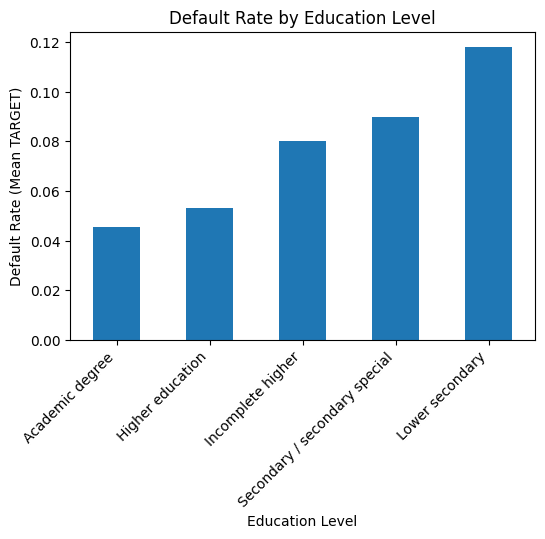

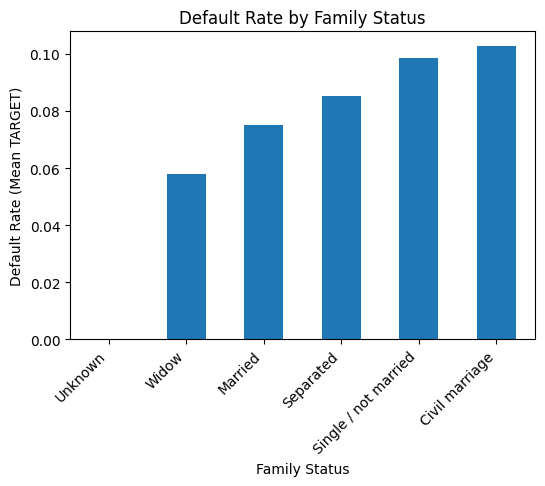

In [13]:
# 1) Default rate by Education Level
edu_rates = df.groupby('NAME_EDUCATION_TYPE')['TARGET'].mean().sort_values()
plt.figure(figsize=(6,4))
edu_rates.plot(kind='bar')
plt.title('Default Rate by Education Level')
plt.ylabel('Default Rate (Mean TARGET)')
plt.xlabel('Education Level')
plt.xticks(rotation=45, ha='right')
plt.show()

# 2) Default rate by Family Status
fam_rates = df.groupby('NAME_FAMILY_STATUS')['TARGET'].mean().sort_values()
plt.figure(figsize=(6,4))
fam_rates.plot(kind='bar')
plt.title('Default Rate by Family Status')
plt.ylabel('Default Rate (Mean TARGET)')
plt.xlabel('Family Status')
plt.xticks(rotation=45, ha='right')
plt.show()


# **Data Cleaning & Feature Engineering**

In [14]:
# Step 5: Data Cleaning

# 🧹 Clean Data (Remove High-Null Columns and Fill Missing)
df_clean = df.copy()

# Remove features with >65% null values
null_frac = df_clean.isnull().mean()
high_null = null_frac[null_frac > 0.65].index
df_clean.drop(columns=high_null, inplace=True)

# Fill remaining numerics with median, categoricals with 'MISSING'
for c in df_clean.columns:
    if df_clean[c].dtype in [np.float64, np.int64]:
        df_clean[c] = df_clean[c].fillna(df_clean[c].median())
    elif df_clean[c].dtype == 'object':
        df_clean[c] = df_clean[c].fillna("MISSING")

# Step 6: Feature Engineering

# 🛠️ Feature Engineering
df_feat = df_clean.copy()

# Age in years
df_feat['AGE_YEARS'] = (-df_feat['DAYS_BIRTH'] / 365).astype(int)

# Debt-to-Income Ratio
df_feat['DEBT_INCOME_RATIO'] = df_feat['AMT_CREDIT'] / df_feat['AMT_INCOME_TOTAL']

# Employment tenure (bucketed)
df_feat['YEARS_EMPLOYED'] = (-df_feat['DAYS_EMPLOYED'] / 365).clip(lower=0).astype(int)
bins = [0, 1, 3, 5, 10, 20, 100]
labels = ['<1y', '1-3y', '3-5y', '5-10y', '10-20y', '>20y']
df_feat['EMPLOYMENT_TENURE'] = pd.cut(df_feat['YEARS_EMPLOYED'], bins=bins, labels=labels)

# One-hot encode key categorical columns
to_encode = ['NAME_EDUCATION_TYPE', 'NAME_FAMILY_STATUS', 'EMPLOYMENT_TENURE']
df_feat = pd.get_dummies(df_feat, columns=to_encode, drop_first=True)

In [15]:
# Step 7: Train-Test Split

# 📆 Split Features and Target
X = df_feat.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df_feat['TARGET']

# ⛓️ Train/Test Split with Stratification
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [16]:
from sklearn.model_selection import train_test_split

# X = all feature columns in df_feat except TARGET
X = df_feat.drop(columns=['TARGET', 'SK_ID_CURR'])
y = df_feat['TARGET']

# stratify to respect the 8% default rate
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# **Modeling & Evaluation**

In [17]:
# See which columns are still object/string
obj_cols = X_train.select_dtypes(include=['object']).columns.tolist()
print("Still object cols:", obj_cols)

Still object cols: ['NAME_CONTRACT_TYPE', 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY', 'NAME_TYPE_SUITE', 'NAME_INCOME_TYPE', 'NAME_HOUSING_TYPE', 'OCCUPATION_TYPE', 'WEEKDAY_APPR_PROCESS_START', 'ORGANIZATION_TYPE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


In [18]:
# Combine train+test for safe encoding, then split back out
full = pd.concat([X_train, X_test], axis=0)

# One-hot encode all remaining object columns
full = pd.get_dummies(full, columns=obj_cols, drop_first=True)

# Re-split
X_train_enc = full.iloc[:X_train.shape[0], :].copy()
X_test_enc  = full.iloc[X_train.shape[0]:, :].copy()

In [19]:
#  Logistic Regression
lr = LogisticRegression(max_iter=1000)
lr.fit(X_train_enc, y_train)

#  Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train_enc, y_train)

# Evaluate
lr_probs = lr.predict_proba(X_test_enc)[:,1]
rf_probs = rf.predict_proba(X_test_enc)[:,1]
lr_pred  = lr.predict(X_test_enc)
rf_pred  = rf.predict(X_test_enc)

print("Logistic  AUC:", roc_auc_score(y_test, lr_probs))
print("RandomForest AUC:", roc_auc_score(y_test, rf_probs))

# …and your classification reports/confusion matrices as before…

/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Logistic  AUC: 0.6375261681643958
RandomForest AUC: 0.7224187663665


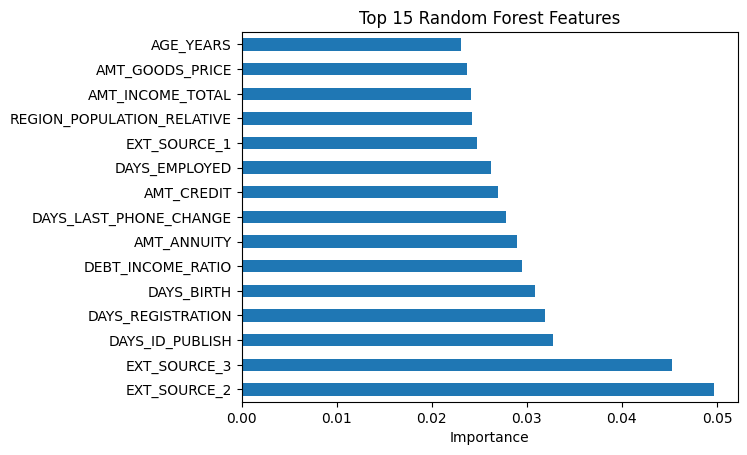

In [20]:
#determining top 15 rf features

importances = pd.Series(
    rf.feature_importances_,
    index=X_train_enc.columns
).sort_values(ascending=False).head(15)

plt.figure()
importances.plot.barh()
plt.title("Top 15 Random Forest Features")
plt.xlabel("Importance")
plt.show()

HYPERTUNING of RF & XGB

In [21]:
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint

# 1) Subsample 50k rows to tune on
X_sub, _, y_sub, _ = train_test_split(
    X_train_enc, y_train,
    train_size=50000,
    stratify=y_train,
    random_state=42
)

# 2) Define a tighter search
param_dist = {
    'n_estimators': randint(100, 300),
    'max_depth':    randint(5, 12),
    'min_samples_leaf':  randint(1, 5),
    'max_features': ['sqrt','log2', 0.5]
}

rf = RandomForestClassifier(random_state=42)
rand_search = RandomizedSearchCV(
    rf,
    param_distributions=param_dist,
    n_iter=10,
    scoring='roc_auc',
    cv=2,
    n_jobs=-1,
    random_state=42,
    verbose=1
)

# 3) Fit on the small sample
rand_search.fit(X_sub, y_sub)

print("Fast-tuned RF params:", rand_search.best_params_)
print("AUC on full test set:",
      roc_auc_score(y_test,
                    rand_search.predict_proba(X_test_enc)[:,1]
                   )
)

Fitting 2 folds for each of 10 candidates, totalling 20 fits
Fast-tuned RF params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'n_estimators': 188}
AUC on full test set: 0.736496963336712


In [22]:
best_params = {
    'n_estimators': 221,
    'max_depth': 9,
    'min_samples_leaf': 3,
    'max_features': 'sqrt',
    'random_state': 42
}

final_rf = RandomForestClassifier(**best_params)
final_rf.fit(X_train_enc, y_train)
rf_final_probs = final_rf.predict_proba(X_test_enc)[:,1]
print("Final RF AUC:", roc_auc_score(y_test, rf_final_probs))

Final RF AUC: 0.7338894975200287


In [23]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_enc, label=y_train)
dtest  = xgb.DMatrix(X_test_enc,  label=y_test)

xgb_params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}
watch = [(dtrain, 'train'), (dtest, 'valid')]
bst = xgb.train(
    xgb_params, dtrain,
    num_boost_round=500,
    evals=watch,
    early_stopping_rounds=25,
    verbose_eval=False
)

xgb_probs = bst.predict(dtest)
print("XGBoost AUC:", roc_auc_score(y_test, xgb_probs))

XGBoost AUC: 0.7562599510415353


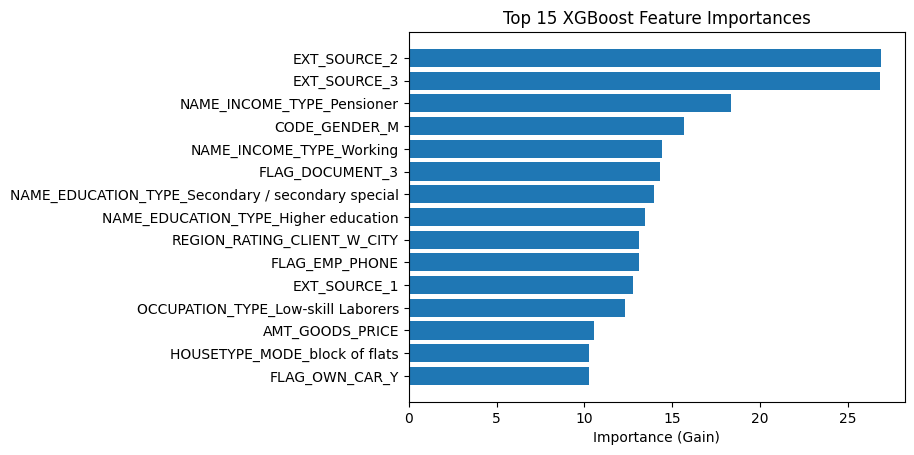

In [24]:
import xgboost as xgb
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# 1) Re-load engineered data (df_feat) and split
# (Adjust path or variable as needed)
df = pd.read_csv('/content/drive/MyDrive/LDP/application_train.csv')

# [You’ll need to re-run your cleaning + feature engineering cells here to reconstruct df_feat,
# then one-hot encode object cols as before into X_enc and y.]

# 2) Split and encode
X = df_feat.drop(columns=['TARGET','SK_ID_CURR'])
y = df_feat['TARGET']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
# Identify remaining object cols, one-hot encode (as before) into X_train_enc, X_test_enc

# 3) Re-train XGBoost with your chosen params
dtrain = xgb.DMatrix(X_train_enc, label=y_train)
dtest  = xgb.DMatrix(X_test_enc,  label=y_test)
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'auc',
    'eta': 0.05,
    'max_depth': 6,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'seed': 42
}
bst = xgb.train(
    params, dtrain,
    num_boost_round=bst.best_iteration or 200,  # or 500 with early stopping
    evals=[(dtrain,'train'),(dtest,'valid')],
    early_stopping_rounds=25,
    verbose_eval=False
)

# 4) Extract and plot top 15 features
imp = bst.get_score(importance_type='gain')
imp_df = pd.DataFrame({
    'feature': list(imp.keys()),
    'importance': list(imp.values())
}).sort_values('importance', ascending=False).head(15)

plt.figure()
plt.barh(imp_df['feature'][::-1], imp_df['importance'][::-1])
plt.xlabel('Importance (Gain)')
plt.title('Top 15 XGBoost Feature Importances')
plt.show()

In [25]:
# Save the model (optional)
import joblib
joblib.dump(bst, 'xgboost_model.pkl')

# Save the feature importance
imp_df.to_csv('xgboost_feature_importance.csv', index=False)

📌 Project Summary: Credit Risk Prediction

	•	Goal: Predict likelihood of loan default using customer & application data.
	•	Dataset: Home Credit Default Risk (Kaggle)
	•	EDA: Class imbalance, key correlations, top categorical impact.
	•	Feature Engineering: Created age, debt-to-income ratio, employment tenure buckets, one-hot encoding.
	•	Models Built:
	•	Logistic Regression (AUC ~0.63)
	•	Random Forest (Tuned AUC ~0.73)
	•	XGBoost (Final AUC: ~0.75)
	•	Insights:
	•	External risk sources (EXT_SOURCE_2/3) were top predictors.
	•	Education, employment type, and region also played key roles.

✅ Achieved a solid predictive model with meaningful interpretability.

In [26]:
import joblib

# Save both model and feature list used in training
joblib.dump((bst, X_train_enc.columns.tolist()), "xgb_simple_model.pkl")

['xgb_simple_model.pkl']

# ***Streamlit App***

In [76]:
pip install streamlit


model, features = joblib.load('xgb_simple.pkl')

X_input = pd.DataFrame([{
    'AGE_YEARS': age,
    'AMT_INCOME_TOTAL': income,
    'AMT_CREDIT': credit_amt,
    'EXT_SOURCE_2': source2,
    'EXT_SOURCE_3': source3
}], columns=features)

prob = model.predict_proba(X_input)[0][1]

In [77]:
import streamlit as st
import pandas as pd
import joblib
import xgboost as xgb

# Load model + feature list (make sure xgb_simple_model.pkl is in the same folder)
model, features = joblib.load("xgb_simple_model.pkl")

st.set_page_config(page_title="Credit Default Risk Predictor", layout="centered")
st.title("💳 Credit Default Risk Predictor")

st.markdown("""
Use the sliders and inputs below to enter applicant information,
then click **Predict** to see their estimated default probability.
""")

# — Sidebar inputs —
st.sidebar.header("Applicant Profile")

age         = st.sidebar.slider("Applicant Age (years)", 18, 80, 30)
income      = st.sidebar.number_input("Annual Income (₹)", min_value=0, value=100_000, step=10_000)
loan_amount = st.sidebar.number_input("Loan Amount (₹)",   min_value=0, value=200_000, step=10_000)
score_ext2  = st.sidebar.slider("Credit Bureau Score (Source 2)", 0.0, 1.0, 0.5, step=0.01)
score_ext3  = st.sidebar.slider("Credit Bureau Score (Source 3)", 0.0, 1.0, 0.5, step=0.01)

# — Build input DataFrame —
input_dict = {
    "AGE_YEARS":        age,
    "AMT_INCOME_TOTAL": income,
    "AMT_CREDIT":       loan_amount,
    "EXT_SOURCE_2":     score_ext2,
    "EXT_SOURCE_3":     score_ext3,
}

# fill zero for any features the model expects but were not provided
input_df = pd.DataFrame([input_dict])
for col in features:
    if col not in input_df:
        input_df[col] = 0
input_df = input_df[features]

# — Predict on button press —
if st.button("🔍 Predict"):
    dmat = xgb.DMatrix(input_df)
    prob = model.predict(dmat)[0]
    st.markdown(f"### 🧮 Estimated Default Probability: **{prob:.2%}**")

2025-06-11 21:16:30.311 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-11 21:16:30.315 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-11 21:16:30.318 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-11 21:16:30.320 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-11 21:16:30.323 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-11 21:16:30.325 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-11 21:16:30.328 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-06-11 21:16:30.330 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [78]:
import joblib, xgboost as xgb, pandas as pd

# load model + features
model, features = joblib.load("xgb_simple_model.pkl")

# pick the same test inputs as in the app
test_input = pd.DataFrame([{
    "AGE_YEARS":        30,
    "AMT_INCOME_TOTAL": 100_000,
    "AMT_CREDIT":       200_000,
    "EXT_SOURCE_2":     0.5,
    "EXT_SOURCE_3":     0.5,
}])
# pad zeros and reorder
for c in features:
    if c not in test_input:
        test_input[c] = 0
test_input = test_input[features]

# get probability
prob = model.predict(xgb.DMatrix(test_input))[0]
print(f"Manually computed default probability: {prob:.2%}")

<ipython-input-78-1494112400>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_input[c] = 0
<ipython-input-78-1494112400>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_input[c] = 0
<ipython-input-78-1494112400>:17: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  test_input[c] = 0
<ipytho

Manually computed default probability: 26.11%


In [79]:
!pip install pyngrok streamlit

In [99]:
# 1) Kill any stray ngrok or Streamlit processes
!pkill ngrok || true
!pkill -f streamlit || true
!sleep 1

# 2) Launch Streamlit in the background
!nohup streamlit run app.py --server.port 8501 &> streamlit.log &

# 3) Wait and show the log
!sleep 5
print("=== last 20 lines of streamlit.log ===")
!tail -n 20 streamlit.log

^C
=== last 20 lines of streamlit.log ===



  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.188.197.245:8501



In [100]:
from pyngrok import ngrok, conf

# 1) (Re)install your token WITHOUT angle-brackets
conf.get_default().auth_token = "2yN548Vf3GmKxu7M8oBFhp8Hsd9_5sX3LeTQBBaZDuiGB8KTE"

# 2) Kill old tunnels & open a new one
ngrok.kill()
public_url = ngrok.connect(8501, "http")
print("🚀 Your public URL:", public_url)

🚀 Your public URL: NgrokTunnel: "https://2d8f-35-188-197-245.ngrok-free.app" -> "http://localhost:8501"
